In [46]:
!pip install Tensorflow
!pip install Keras
!pip install scikit-learn
!pip install imblearn
!pip install scikeras
!pip install gensim


In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.utils import set_random_seed
from tensorflow.data import Dataset


from gensim.models import Word2Vec
import os
import zipfile

In [48]:
set_random_seed(8)

## Importing the data

In [49]:
df = pd.read_csv('data/processed_data.csv', index_col =0)
df

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails congress falling short g...,0
2,eat veggies deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word streaming...,1
...,...,...
28614,jews celebrate rosh hashasha something,1
28615,internal affairs investigator disappointed con...,1
28616,beautiful acceptance speech week came queer ko...,0
28617,mars probe destroyed orbiting spielberggates s...,1


In [50]:
df.isna().sum()

headline        2
is_sarcastic    0
dtype: int64

In [51]:
df.dropna(inplace = True)

In [52]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [53]:
df.shape

(28615, 2)

## Splitting data

In [54]:
X = df["headline"]
y = df["is_sarcastic"]

splitting data 70\% train, 10\% validation, 20\% test

In [55]:
#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, random_state = 8)

In [56]:
#splitting the (training) data into training and validating data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.125)

In [57]:
X_train.sample(5)

20018                    reports movie good reach area man
2706     trumps labor law enforcer freezes workerfriend...
24071    rohingya muslims flee  houses burned myanmars ...
12386                     havana attractions cant wait see
5098     wildest friend called bench help woman get bre...
Name: headline, dtype: object

In [58]:
y_train.sample(5)

15871    1
1068     1
26259    1
885      0
18231    0
Name: is_sarcastic, dtype: int64

## Model statistics

In [99]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

## Tokenizing

In [59]:
tokenizer = Tokenizer()

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#finding the max length of a sentence in the training data to padd sequences later on
max_length = max([len(sentence.split()) for sentence in X_train])

#tokenizing headlines
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_length, padding = "post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_length, padding = "post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_length, padding = "post")

In [72]:
max_length

106

In [68]:
vocab_size = len(tokenizer.word_index)+1
print(f'The size of vocabulary: {vocab_size}')

The size of vocabulary: 24121


## Simple bidirectional GRU

With own embedding

In [86]:
output_dimension = 100

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length))
model.add(Bidirectional(GRU(128)))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 106, 100)          2412100   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               176640    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2588997 (9.88 MB)
Trainable params: 2588997 (9.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [88]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, validation_data=(X_val, y_val))

Epoch 1/5
313/313 [==============================] - 81s 246ms/step - loss: 0.4910 - accuracy: 0.7502 - val_loss: 0.3836 - val_accuracy: 0.8194
Epoch 2/5
313/313 [==============================] - 75s 240ms/step - loss: 0.2084 - accuracy: 0.9183 - val_loss: 0.4176 - val_accuracy: 0.8173
Epoch 3/5
313/313 [==============================] - 59s 187ms/step - loss: 0.0825 - accuracy: 0.9700 - val_loss: 0.5692 - val_accuracy: 0.8043
Epoch 4/5
313/313 [==============================] - 71s 226ms/step - loss: 0.0352 - accuracy: 0.9884 - val_loss: 0.7902 - val_accuracy: 0.7914
Epoch 5/5
313/313 [==============================] - 74s 236ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.8280 - val_accuracy: 0.7970


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_9300\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


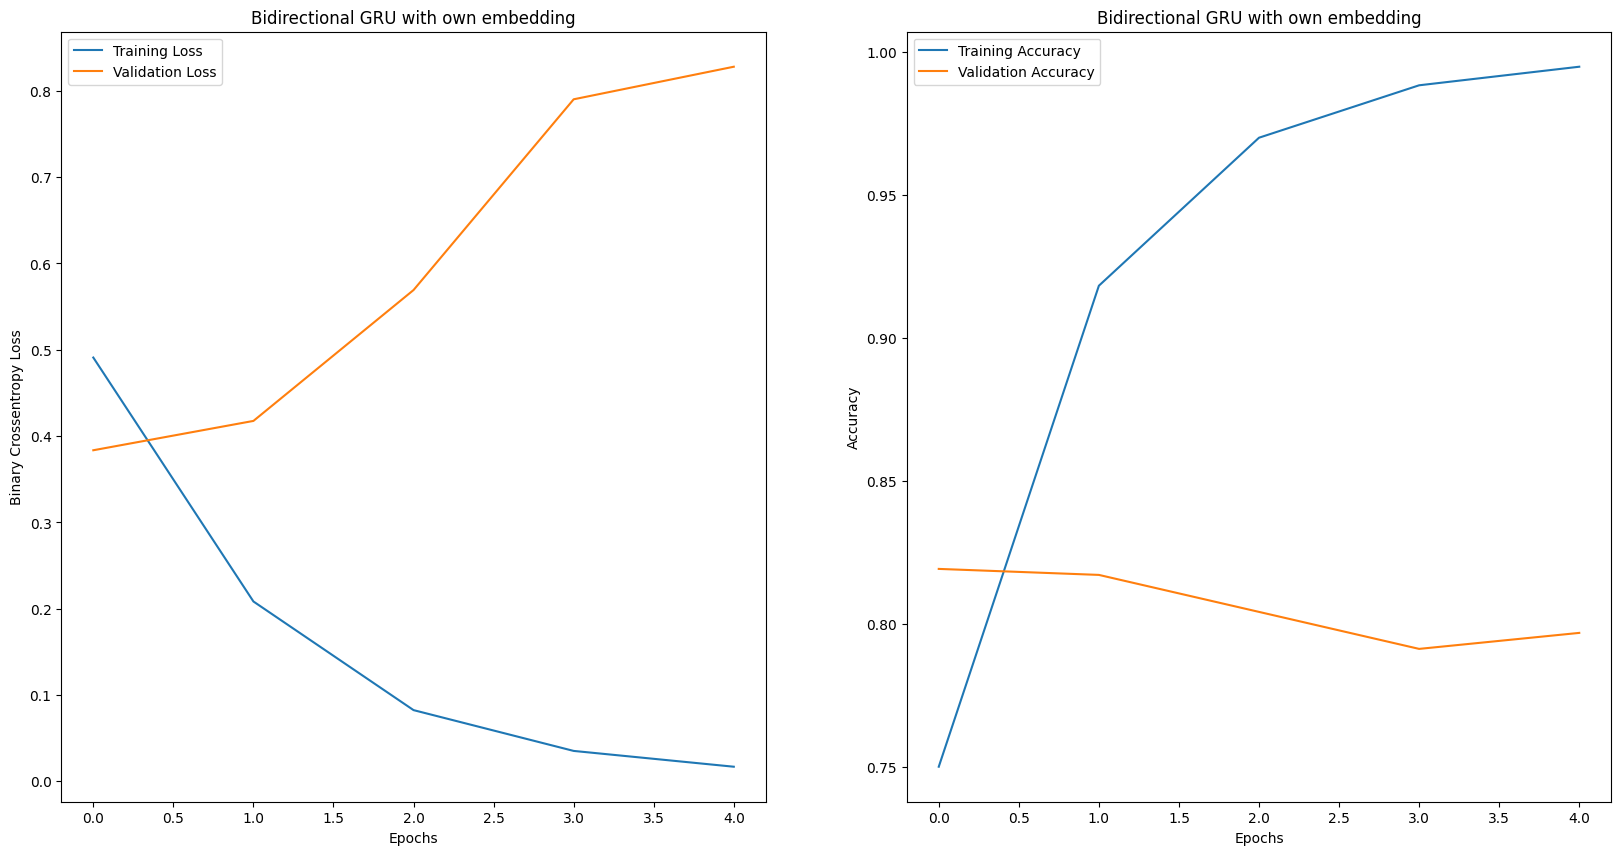

In [100]:
plotCurves(history, "Bidirectional GRU with own embedding")